# Classificazione Binaria: `selfMade` con K-NEAREST NEIGHOBOR

In [51]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import os

# Caricamento dati
X_train = pd.read_csv("../data/splitted/X_train.csv")
X_test = pd.read_csv("../data/splitted/X_test.csv")
y_train = pd.read_csv("../data/splitted/y_train.csv").values.ravel()
y_test = pd.read_csv("../data/splitted/y_test.csv").values.ravel()

#print(X_train.nunique())
#print(X_train.isna().sum())
#print(np.isinf(X_train).sum())


print("Colonne con solo NaN:")
print(X_train.columns[X_train.isna().all()])

print("Colonne costanti:")
print(X_train.columns[X_train.nunique() <= 1])

# Rimozione colonne inutili o problematiche
X_train = X_train.drop(columns=['source'], errors='ignore')  # elimino colonna tutta NaN
X_train = X_train.loc[:, X_train.nunique() > 1]  # elimino colonne costanti

# Allineamento test set
X_test = X_test[X_train.columns]

# Riempio NaN residui con la mediana
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())








Colonne con solo NaN:
Index(['source'], dtype='object')
Colonne costanti:
Index(['source', 'country_Lebanon', 'country_Nepal', 'country_Oman',
       'country_Uzbekistan'],
      dtype='object')


In [52]:
# Per operare correttamente gli attributi devono avere la stessa scala di valori e vanno normalizzati in fase di pre-processing
# standardizzazione

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Parametri del modello
k = 19
model_name = f"knn_k{k}"

# Addestramento modello KNN
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train_scaled, y_train)

# Predizioni
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

In [54]:
# Metriche
train_metrics = {
    "Accuracy": accuracy_score(y_train, y_pred_train),
    "Precision": precision_score(y_train, y_pred_train),
    "Recall": recall_score(y_train, y_pred_train),
    "F1-Score": f1_score(y_train, y_pred_train),
    "Confusion Matrix": confusion_matrix(y_train, y_pred_train).tolist()
}
test_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_test),
    "Precision": precision_score(y_test, y_pred_test),
    "Recall": recall_score(y_test, y_pred_test),
    "F1-Score": f1_score(y_test, y_pred_test),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_test).tolist()
}

# Salvataggio risultati
output_dir = "../results/classification_selfMade/KNN"
os.makedirs(output_dir, exist_ok=True)

filename = os.path.join(output_dir, f"{model_name}_metrics.txt")
with open(filename, "w") as f:
    f.write(f"Modello: KNeighborsClassifier (k={k})\n\n")

    f.write("TRAIN METRICS:\n")
    for k, v in train_metrics.items():
        if k == "Confusion Matrix":
            f.write("Confusion Matrix:\n")
            f.write(f"{v}\n")
        else:
            f.write(f"{k}: {v:.4f}\n")

    f.write("\nTEST METRICS:\n")
    for k, v in test_metrics.items():
        if k == "Confusion Matrix":
            f.write("Confusion Matrix:\n")
            f.write(f"{v}\n")
        else:
            f.write(f"{k}: {v:.4f}\n")

print(f"✔ Metriche salvate in: {filename}")


✔ Metriche salvate in: ../results/classification_selfMade/KNN\knn_k52_metrics.txt


# Applico strategie per trovare il valore di k ottimale

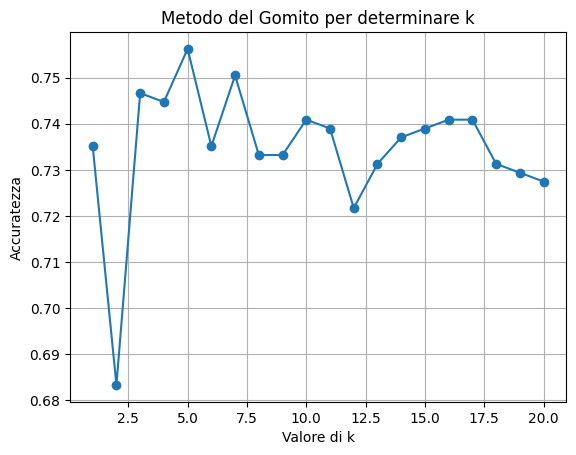

✔ Grafico salvato in: ../results/classification_selfMade/KNN/gomito_KNN_accuracy.png


In [55]:
# METODO DEL GOMITO

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k_values = range(1, 21)
# nota: con valori più alti, ad esempio fino a 100 l'accuratezza diminuisce
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    accuracies.append(accuracy_score(y_test, y_pred))

plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Valore di k')
plt.ylabel('Accuratezza')
plt.title('Metodo del Gomito per determinare k')
plt.grid(True)
output_path = "../results/classification_selfMade/KNN/gomito_KNN_accuracy.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path)
plt.show()
plt.close()

print(f"✔ Grafico salvato in: {output_path}")



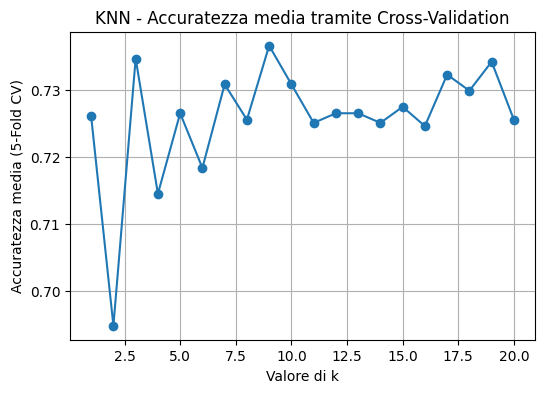

✔ Miglior valore di k trovato con CV e concentrazione su accuracy: 9


In [57]:
# CROSS VALIDATION
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

k_values = range(1, 21)
cv_scores = []

# Cross-validation su ogni k
for k in k_values:
    knn_pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
    scores = cross_val_score(knn_pipeline, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# 📈 Plot
plt.figure(figsize=(6, 4))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel("Valore di k")
plt.ylabel("Accuratezza media (5-Fold CV)")
plt.title("KNN - Accuratezza media tramite Cross-Validation")
plt.grid(True)

# Salvataggio
output_path = "../results/classification_selfMade/KNN/cv_knn_accuracy.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path)
plt.show()
plt.close()

# Miglior k
best_k = k_values[np.argmax(cv_scores)]
print(f"✔ Miglior valore di k trovato con CV e concentrazione su accuracy: {best_k}")



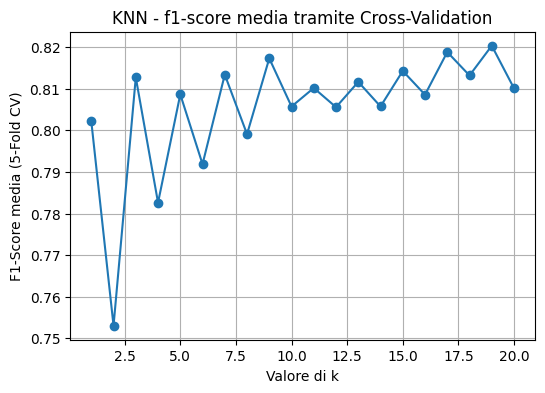

✔ Miglior valore di k trovato con CV e concentrazione su f1: 19


In [58]:
k_values = range(1, 21)
cv_scores = []

for k in k_values:
    knn_pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
    scores = cross_val_score(knn_pipeline, X_train, y_train, cv=5, scoring='f1')
    cv_scores.append(scores.mean())

# 📈 Plot
plt.figure(figsize=(6, 4))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel("Valore di k")
plt.ylabel("F1-Score media (5-Fold CV)")
plt.title("KNN - f1-score media tramite Cross-Validation")
plt.grid(True)

# Salvataggio
output_path = "../results/classification_selfMade/KNN/cv_knn_f1.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path)
plt.show()
plt.close()

# Miglior k
best_k = k_values[np.argmax(cv_scores)]
print(f"✔ Miglior valore di k trovato con CV e concentrazione su f1: {best_k}")


